# XGBoost Analysis

## Setup

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [5]:
# Load data
data = pd.read_csv('data/Ames_XGB.csv')

In [6]:
# Create the independent variables and the target
predictors = data.drop('SalePrice', axis=1)
target = data['SalePrice']

In [7]:
# Check columns
column_names = predictors.columns
for column in column_names:
    print(column)

GrLivArea
LotFrontage
LotArea
OverallQual
OverallCond
MasVnrArea
ExterQual
ExterCond
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
YearsSinceBuilt
YearsSinceRemod
Crisis
MSZoning_C (all)
MSZoning_FV
MSZoning_I (all)
MSZoning_RH
MSZoning_RL
MSZoning_RM
Street_Pave
Alley_None
Alley_Pave
LotShape_IR2
LotShape_IR3
LotShape_Reg
LandContour_HLS
LandContour_Low
LandContour_Lvl
Utilities_NoSewr
LotConfig_CulDSac
LotConfig_FR2
LotConfig_FR3
LotConfig_Inside
LandSlope_Mod
LandSlope_Sev
Neighborhood_Blueste
Neighborhood_BrDale
Neighborhood_BrkSide
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_Greens
Neighborhood_GrnHill
Neighborhood_IDOTRR
Neighborhood_Landmrk
Neighborhood_MeadowV
Ne

In [8]:
# Check info on predictors
print(predictors.info())    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 263 entries, GrLivArea to SaleCondition_Partial
dtypes: float64(7), int64(256)
memory usage: 5.2 MB
None


In [9]:
# View data
predictors.head()

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,856,0.0,7890,5,5,0.0,3,3,238.0,0.0,...,0,0,0,0,1,0,0,0,1,0
1,1049,42.0,4235,4,4,149.0,4,3,552.0,393.0,...,0,0,0,0,1,0,0,0,1,0
2,1001,60.0,6060,4,8,0.0,4,3,737.0,0.0,...,0,0,0,0,1,0,0,0,1,0
3,1039,80.0,8146,3,7,0.0,4,4,0.0,0.0,...,0,0,0,0,1,0,0,0,1,0
4,1665,70.0,8400,7,5,0.0,4,3,643.0,0.0,...,0,0,0,0,1,0,0,0,1,0


## Split Train-Test Sets

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state=0, test_size = 0.2)

In [12]:
# Check training set features and target
print(X_train.shape)
print(y_train.shape)

(2063, 263)
(2063,)


## Train Model

In [13]:
# Initialize a XGBRegressor object
xgbr = xgb.XGBRegressor()

In [14]:
# Define the grid of hyperparameters to search
params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'alpha': [0, 10, 20],
    'n_estimators': [10, 50, 100, 200],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'objective': ['reg:squarederror']
}

In [16]:
# Initialize a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgbr, 
                           param_grid=params, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=1, 
                           n_jobs=-1)

In [17]:
# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0,

In [18]:
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'alpha': 0, 'colsample_bytree': 0.3, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror'}


## Evaluate Model

In [25]:
# Initialize a new XGBoost regressor using the best parameters
best_xgbr = xgb.XGBRegressor(**best_params)

In [26]:
# Fit the best XGBoost regressor to the data
best_xgbr.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [27]:
# Predict the train set
y_pred_train = best_xgbr.predict(X_train)

# Compute the R^2 score for the train set
r2_train = r2_score(y_train, y_pred_train)
print(f'R^2 score: {r2_train}')

R^2 score: 0.9870520369991149


In [28]:
# Predict the test set
y_pred_test = best_xgbr.predict(X_test)

# Compute the R^2 score for the test set
r2_test = r2_score(y_test, y_pred_test)
print(f'R^2 score: {r2_test}')

R^2 score: 0.9324263833011578


## Feature Importances

In [29]:
# List top 5 features
importances = best_xgbr.feature_importances_
feature_importances = pd.DataFrame({'Feature': predictors.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances.head(5))

            Feature  Importance
3       OverallQual    0.181912
24       GarageCars    0.135873
0         GrLivArea    0.077477
35  YearsSinceBuilt    0.045363
8        BsmtFinSF1    0.038453


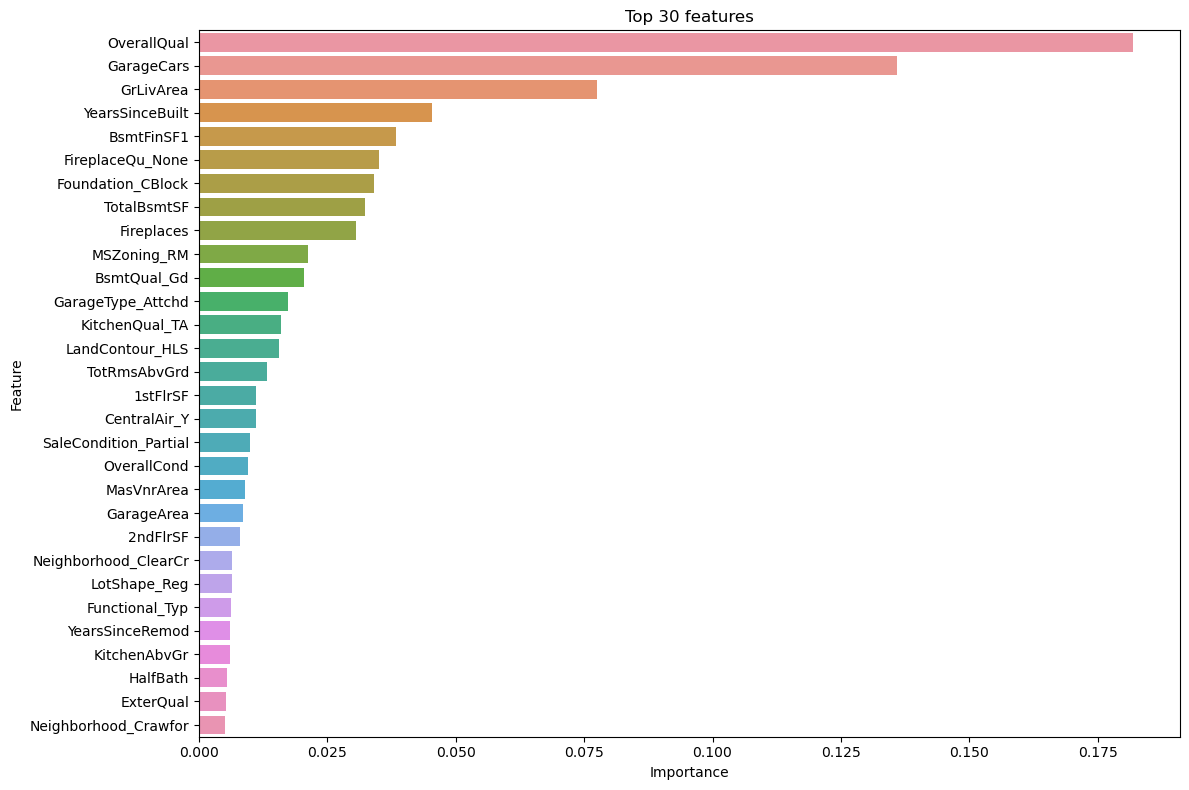

In [30]:
# Get the top 30 features
feature_importances_top_30 = feature_importances.head(30)

# Plot the top 30 features
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_top_30)
plt.title('Top 30 features')
plt.tight_layout()
plt.show()